In [1]:
# TRY MCMC STUFF PLAYING WITH EPSILON

In [2]:
import math
import random
import decimal
import scipy.linalg
import numpy.random as nrand
import matplotlib.pyplot as plt
import gpflow
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

C:\Anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Anaconda\lib\site-packages\multipledispatch\dispatcher.py:24: AmbiguityWarning: 
Ambiguities exist in dispatched function _expectation

The following signatures may result in ambiguous behavior:
	[Gaussian, Identity, NoneType, Kernel, InducingPoints], [Gaussian, Linear, NoneType, Sum, InducingPoints]


Consider making the following additions:

@dispatch(Gaussian, Identity, NoneType, Sum, InducingPoints)
def _expectation(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


In [3]:
def ou_values(a,b,dt,sigma,time):
    #This method returns the rate levels of a mean-reverting ornstein uhlenbeck process.
    x = np.zeros(len(time))
    for i in range(0, len(time)-1):
        x[i+1]=x[i]+a*(b-x[i])*dt+math.sqrt(dt)*sigma*np.random.normal(0,1)
    return x

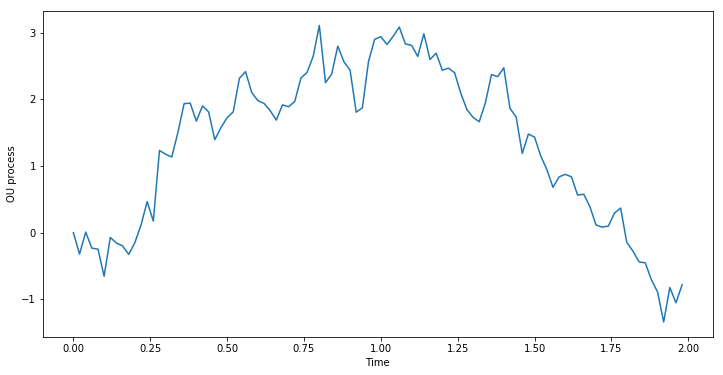

In [4]:
dt=0.02
time=np.arange(0,2,dt)# time
sigma=2
a=1# the coefficient in front, the rate
b=0# the mean
#Simulation of an OU process
x=ou_values(a,b,dt,sigma,time)# the first one is zero because param_all_r0 starts at 0
t=time# time vector
plt.plot(t,x)
plt.xlabel('Time')
plt.ylabel('OU process')
plt.show()

In [5]:
t_column=t.reshape(-1,1)
x_column=x.reshape(-1,1)

In [6]:
k=gpflow.kernels.Matern52(1, lengthscales=0.3)
meanf = gpflow.mean_functions.Linear(1.0, 0.0)
m = gpflow.models.GPR(t_column,x_column, k, meanf)
m.likelihood.variance = 0.1# get this to be bigger

In [7]:
m.clear()
m.kern.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern.variance.prior = gpflow.priors.Gamma(1., 1.)
m.likelihood.variance.prior = gpflow.priors.Gamma(1., 1.)
m.mean_function.A.prior = gpflow.priors.Gaussian(0., 10.)
m.mean_function.b.prior = gpflow.priors.Gaussian(0., 10.)
m.compile()
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/mean_function/A,Parameter,"N([0.],[10.])",(none),True,"(1, 1)",True,[[1.0]]
GPR/mean_function/b,Parameter,"N([0.],[10.])",(none),True,(),True,0.0
GPR/kern/variance,Parameter,"Ga([1.],[1.])",+ve,True,(),True,1.0
GPR/kern/lengthscales,Parameter,"Ga([1.],[1.])",+ve,True,(),True,0.3
GPR/likelihood/variance,Parameter,"Ga([1.],[1.])",+ve,True,(),True,0.1


In [26]:
sampler = gpflow.train.HMC()
samples = sampler.sample(m, num_samples=gpflow.test_util.notebook_niter(10000), epsilon=0.5,logprobs=False)#,lmin=10, lmax=20)

Text(0,0.5,'parameter value')

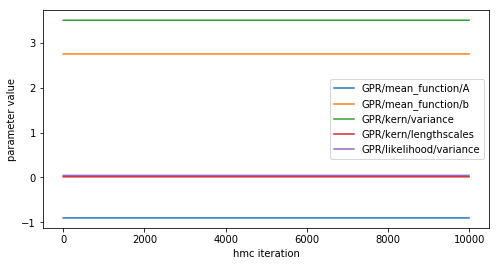

In [27]:
plt.figure(figsize=(8,4))
for i, col in samples.iteritems():
    plt.plot(col, label=col.name)
plt.legend(loc=0)
plt.xlabel('hmc iteration')
plt.ylabel('parameter value')

Text(0,0.5,'signal_variance')

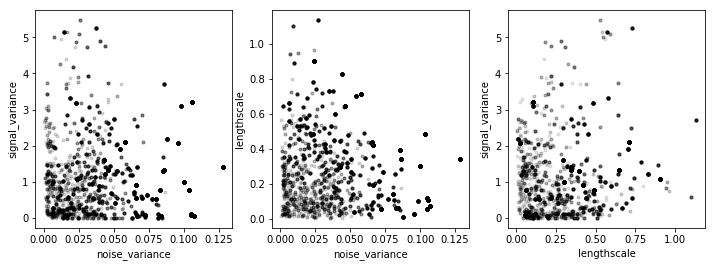

In [10]:
f, axs = plt.subplots(1,3, figsize=(12,4))

axs[0].plot(samples['GPR/likelihood/variance'],
            samples['GPR/kern/variance'], 'k.', alpha = 0.15)
axs[0].set_xlabel('noise_variance')
axs[0].set_ylabel('signal_variance')

axs[1].plot(samples['GPR/likelihood/variance'],
            samples['GPR/kern/lengthscales'], 'k.', alpha = 0.15)
axs[1].set_xlabel('noise_variance')
axs[1].set_ylabel('lengthscale')

axs[2].plot(samples['GPR/kern/lengthscales'],
            samples['GPR/kern/variance'], 'k.', alpha = 0.1)
axs[2].set_xlabel('lengthscale')
axs[2].set_ylabel('signal_variance')

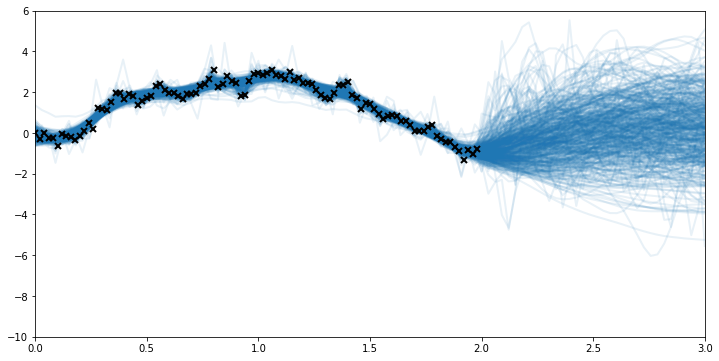

In [11]:
#plot the function posterior
xx = np.linspace(0, 3, 100)[:,None]
plt.figure(figsize=(12, 6))
for i, s in samples.iloc[::20].iterrows():
    f = m.predict_f_samples(xx, 1, initialize=False, feed_dict=m.sample_feed_dict(s))
    plt.plot(xx, f[0,:,:], 'C0', lw=2, alpha=0.1)
    
plt.plot(t, x, 'kx', mew=2)
_ = plt.xlim(xx.min(), xx.max())
_ = plt.ylim(-10, 6)